In [1]:
import os
import json
import time
import random
import itertools

# Third-party imports
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# TensorFlow and Keras imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras_tuner import BayesianOptimization

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Generate data paths with labels
data_dir = '/kaggle/input/handwritten-digits-0-9'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
# Generate datapath untuk eksternal dataset tes
data_direks = '/kaggle/input/dataeksternalangka/Eksternaldataset'
filepaths2 = []
labels2 = []

folds2 = os.listdir(data_direks)
for fold in folds2:
    foldpath2 = os.path.join(data_direks, fold)
    filelist2 = os.listdir(foldpath2)
    for file in filelist2:
        fpath2 = os.path.join(foldpath2, file)
        filepaths2.append(fpath2)
        labels2.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries2 = pd.Series(filepaths2, name= 'filepaths2')
Lseries2 = pd.Series(labels2, name='labels2')
df2 = pd.concat([Fseries2, Lseries2], axis= 1)

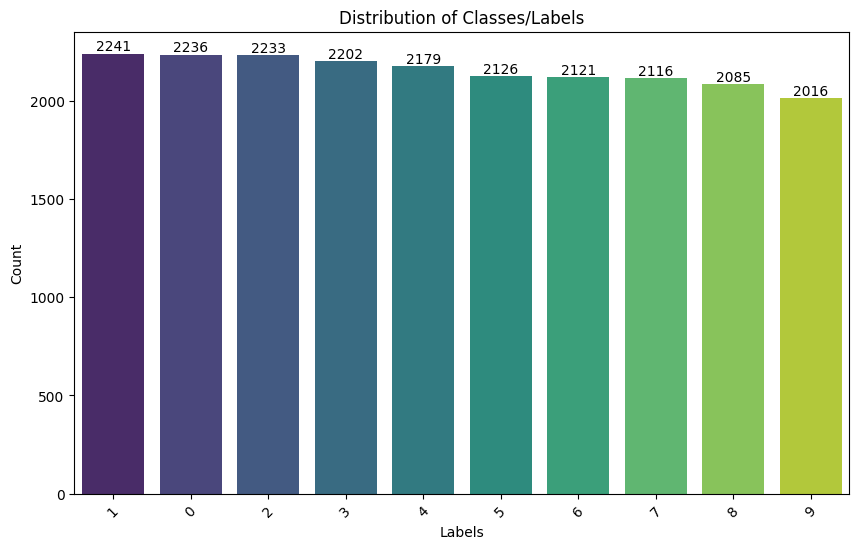

In [4]:
# Count the occurrences of each label
label_counts = df['labels'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Classes/Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Add data labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')

plt.show()

In [5]:
# Data Splitting
# Train dataframe (70% of the original data)
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123)

# Validation and test dataframes (split remaining 30% into 20% validation and 10% test)
valid_df, test_df = train_test_split(dummy_df, train_size=2/3, shuffle=True, random_state=123)

In [6]:
# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalization
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

# Only rescaling for validation & test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(64, 64),
    batch_size=32,
    color_mode= 'rgb',
    shuffle= True,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(64, 64),
    batch_size=32,
    color_mode= 'rgb',
    shuffle= True,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(64, 64),
    batch_size=32,
    color_mode= 'rgb',
    shuffle= False,
    class_mode='categorical'
)

print("\nTrain class indices:", train_generator.class_indices)
print("Validation class indices:", val_generator.class_indices)
print("Test class indices:", test_generator.class_indices)

Found 15088 validated image filenames belonging to 10 classes.
Found 4311 validated image filenames belonging to 10 classes.
Found 2156 validated image filenames belonging to 10 classes.

Train class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
Validation class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
Test class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


In [8]:
testext_generator = test_datagen.flow_from_dataframe(
    df2,
    x_col='filepaths2',
    y_col='labels2',
    target_size=(64, 64),
    batch_size=32,
    color_mode= 'rgb',
    shuffle= False,
    class_mode='categorical'
)
print("Test class indices:", testext_generator.class_indices)

Found 71 validated image filenames belonging to 10 classes.
Test class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


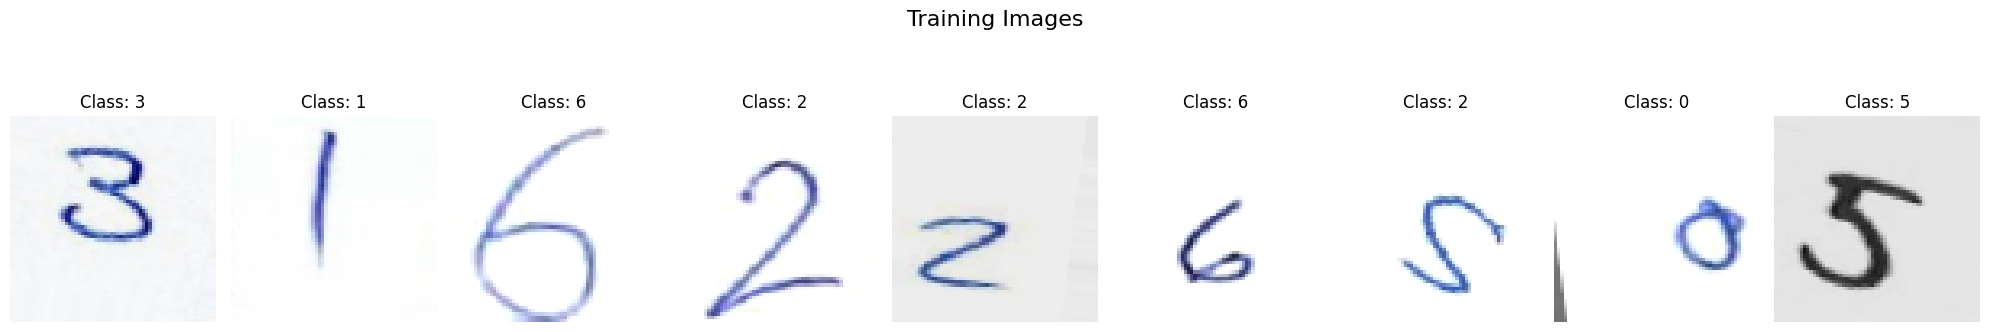

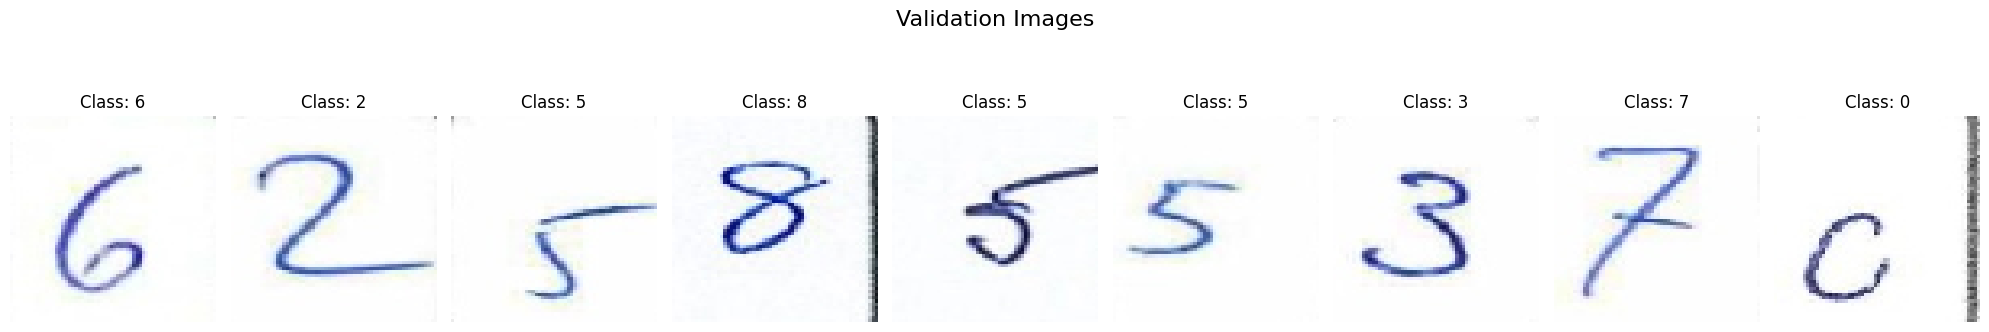

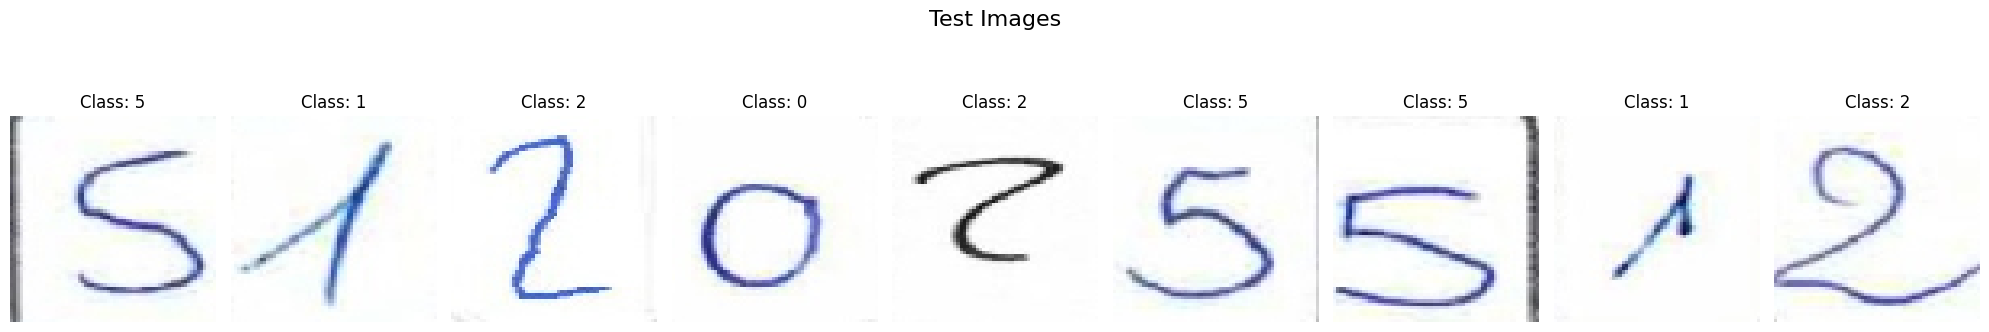

In [9]:
#Output Sampel gambar
def plot_images(generator, title, n=9):
    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)
    has_classes = hasattr(generator, 'class_indices')
    if has_classes:
        class_indices = generator.class_indices
        index_to_class = {v: k for k, v in class_indices.items()}
    for i in range(n):
        batch = next(generator)
        if isinstance(batch, tuple):
            images, labels = batch
        else:
            images = batch
        idx = np.random.randint(0, images.shape[0])
        img = images[idx]
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        if has_classes and isinstance(batch, tuple):
            label_idx = np.argmax(labels[idx])
            class_name = index_to_class[label_idx]
            plt.title(f"Class: {class_name}")
    plt.tight_layout()
    plt.show()

plot_images(train_generator, "Training Images")
plot_images(val_generator, "Validation Images")
plot_images(test_generator, "Test Images")

In [10]:
# Define the model-building function for Keras Tuner
def build_model(hp):
    class_count = len(list(train_generator.class_indices.keys()))

    # Load base model
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(64, 64, 3),
        pooling='max'
    )
    base_model.trainable = True

    # Add custom classification head
    x = base_model.output
    x = Flatten()(x)

    # Tune the number of units in the Dense layer
    units = hp.Int('units', min_value=64, max_value=128, step=32)
    x = Dense(units, activation='relu')(x)

    # Optional: Tune dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    x = Dropout(dropout_rate)(x)

    # Output layer
    predictions = Dense(class_count, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with a tunable learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [11]:
# Initialize the Keras Tuner with Bayesian Optimization
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=7,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times to train each model for more stable results
    directory='malaria2_hypertuning',
    project_name='malaria_classification_bayesian'
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [12]:
# Catat waktu mulai
start_time = time.time()

# Jalankan tuning hyperparameter
tuner.search(
    train_generator,
    epochs=3,
    validation_data=val_generator,
    callbacks=[EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]
)

# Catat waktu selesai dan hitung waktu total
end_time = time.time()
total_time = end_time - start_time
print(f"Total tuning time: {total_time // 60:.0f} minutes and {total_time % 60:.0f} seconds")

Trial 7 Complete [00h 04m 21s]
val_accuracy: 0.9443284869194031

Best val_accuracy So Far: 0.9443284869194031
Total elapsed time: 00h 31m 20s
Total tuning time: 31 minutes and 20 seconds


In [13]:
# Mendapatkan hyperparameter terbaik dan akurasi terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluasi model terbaik pada validation set untuk mendapatkan akurasi terbaik
best_val_loss, best_val_accuracy = best_model.evaluate(val_generator)
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Print dan simpan hyperparameter terbaik
best_hps_dict = {
    'units': best_hps.get('units'),
    'dropout_rate': best_hps.get('dropout_rate'),
    'learning_rate': best_hps.get('learning_rate')
}
print("\nBest Hyperparameters:")
for key, value in best_hps_dict.items():
    print(f"{key}: {value}")

135/135 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9479 - loss: 0.1688
Best Validation Accuracy: 0.9443
Best Validation Loss: 0.1820

Best Hyperparameters:
units: 128
dropout_rate: 0.30000000000000004
learning_rate: 0.00019604971885111013


In [14]:
# Simpan ke file JSON
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hps_dict, f)

In [15]:
# Muat hyperparameter terbaik dari file JSON
with open('best_hyperparameters.json', 'r') as f:
    best_hps_dict = json.load(f)

class_count = len(list(train_generator.class_indices.keys()))

# Bangun model dengan hyperparameter terbaik yang dimuat
best_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3),
    pooling='max'
)

best_model.trainable = True

# Tambahkan custom classification head
x = best_model.output
x = Flatten()(x)
x = Dense(best_hps_dict['units'], activation='relu')(x)
x = Dropout(best_hps_dict['dropout_rate'])(x)
predictions = Dense(class_count, activation='softmax')(x)

# Model akhir
model = Model(inputs=best_model.input, outputs=predictions)

# Kompilasi model dengan learning rate terbaik
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=best_hps_dict['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 64, 64, 3)      │              0 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 32, 32, 32)     │            864 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 32, 32, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 32, 32, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 32, 32, 16)     │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 32, 32, 16)     │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 32, 32, 16)     │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, 16, 16, 64)     │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, 16, 16, 64)     │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, 16, 16, 64)     │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, 16, 16, 32)     │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, 16, 16, 32)     │            128 │ block2a_project_conv[… │
│ (BatchNormalization) 

 Total params: 6,084,570 (23.21 MB)

 Trainable params: 6,023,962 (22.98 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# Checkpoint to save the entire model
model_checkpoint_full = ModelCheckpoint(
    'EffNetV2B0.keras',
    save_best_only=True,
    monitor='val_loss',
    save_weights_only=False
)

# Checkpoint to save only the weights
model_checkpoint_weights = ModelCheckpoint(
    'EffNetV2B0.weights.h5',
    save_best_only=True,
    monitor='val_loss',
    save_weights_only=True
)

In [17]:
# Measure training time
start_time = time.time()

# Use both checkpoints in training
history_effnetv2b0 = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping,
               reduce_lr,
               model_checkpoint_full,
               model_checkpoint_weights]
)

end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal training time: {total_time // 60:.0f} minutes and {total_time % 60:.0f} seconds")

Epoch 1/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 146s 178ms/step - accuracy: 0.3813 - loss: 1.8917 - val_accuracy: 0.8012 - val_loss: 0.6555 - learning_rate: 1.9605e-04
Epoch 2/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 53s 111ms/step - accuracy: 0.8490 - loss: 0.4731 - val_accuracy: 0.8780 - val_loss: 0.3783 - learning_rate: 1.9605e-04
Epoch 3/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 53s 111ms/step - accuracy: 0.9104 - loss: 0.2808 - val_accuracy: 0.9594 - val_loss: 0.1260 - learning_rate: 1.9605e-04
Epoch 4/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 53s 110ms/step - accuracy: 0.9340 - loss: 0.2104 - val_accuracy: 0.8304 - val_loss: 0.5350 - learning_rate: 1.9605e-04
Epoch 5/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 53s 112ms/step - accuracy: 0.9497 - loss: 0.1669 - val_accuracy: 0.8219 - val_loss: 0.5496 - learning_rate: 1.9605e-04
Epoch 6/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 54s 113ms/step - accuracy: 0.9571 - loss: 0.1334 - val_accuracy: 0.9587 - val_loss: 0.1454 - learning_rate: 1.9605e-04
Epoch 7/50
472/472 ━━━━━━━━━━━━━━━━━━━━ 53s 1

In [18]:
# Simpan data history model EfficientNetV2B0
with open('history_effnetv2b0.json', 'w') as save_history_effnetv2b0:
    json.dump(history_effnetv2b0.history, save_history_effnetv2b0)

In [19]:
# Muat data history dari file JSON
with open('history_effnetv2b0.json', 'r') as read_history_effnetv2b0:
    history_dict_effnetv2b0 = json.load(read_history_effnetv2b0)

# Memuat model yang telah disimpan
model_effnetv2b0 = load_model('EffNetV2B0.keras')

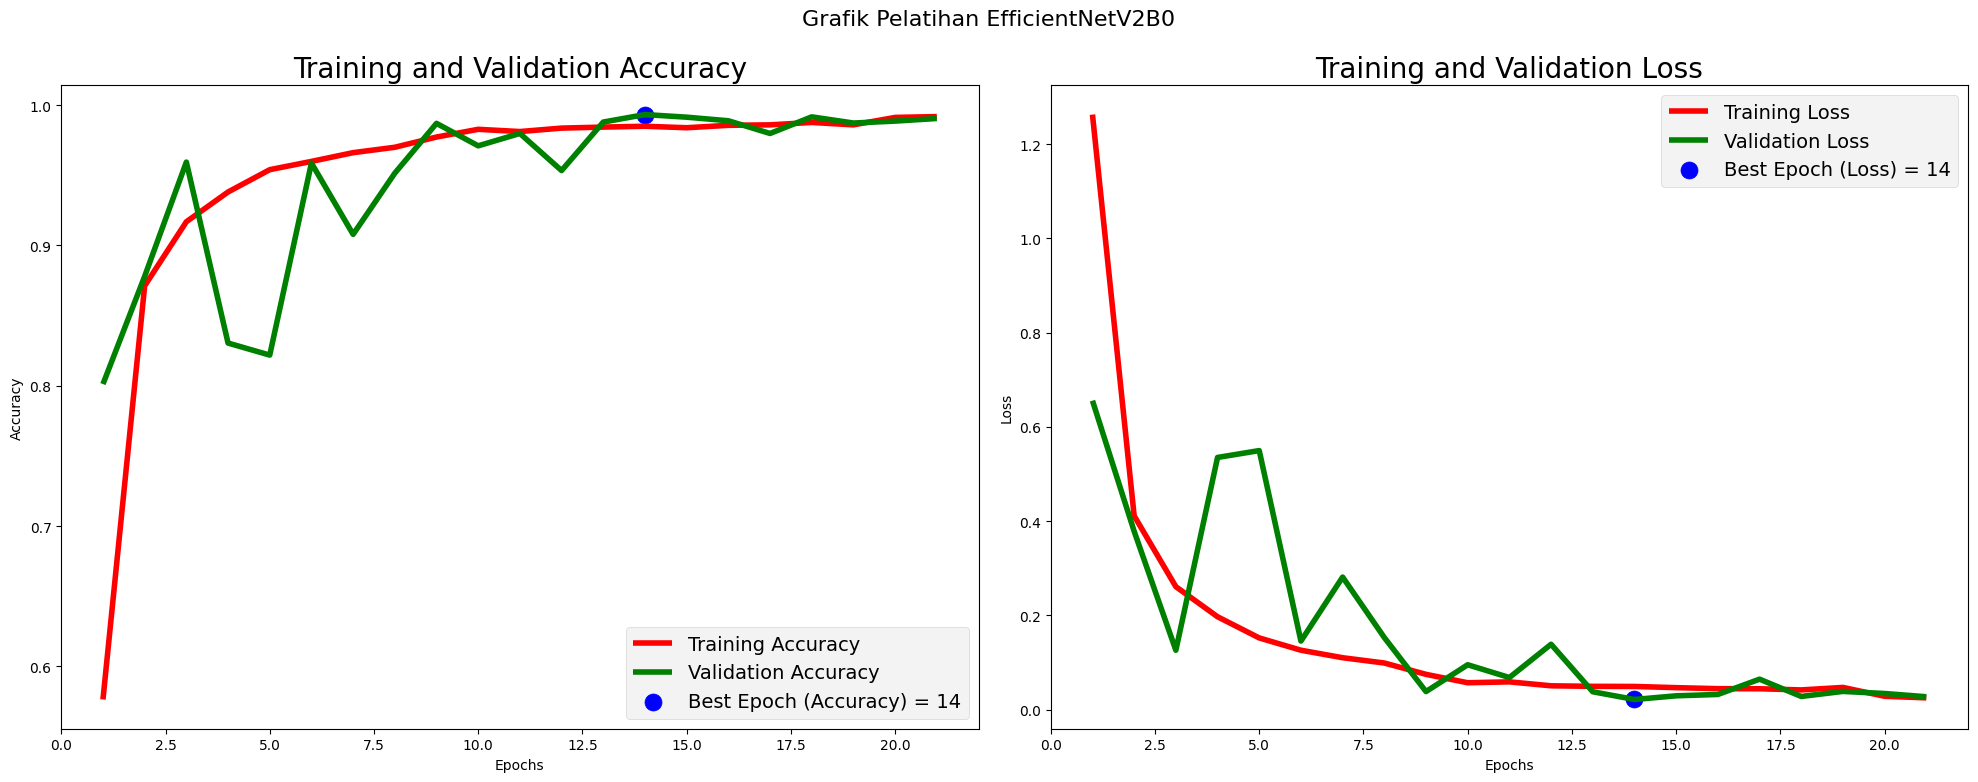

In [20]:
def plot_training_history(history_dict, title):
    # Extract accuracy and loss values
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    # Find best epoch indices for loss and accuracy
    index_loss = np.argmin(val_loss_values)
    val_lowest = val_loss_values[index_loss]
    index_acc = np.argmax(val_acc_values)
    acc_highest = val_acc_values[index_acc]

    # Set up epoch range
    epochs = range(1, len(acc_values) + 1)
    loss_label = f'Best Epoch (Loss) = {index_loss + 1}'
    acc_label = f'Best Epoch (Accuracy) = {index_acc + 1}'

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(title, fontsize=16)
    plt.style.use('fivethirtyeight')

    # Plot Training and Validation Accuracy
    ax[0].plot(epochs, acc_values, 'r', label='Training Accuracy')
    ax[0].plot(epochs, val_acc_values, 'g', label='Validation Accuracy')
    ax[0].scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)  # Mark best accuracy epoch
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Plot Training and Validation Loss
    ax[1].plot(epochs, loss_values, 'r', label='Training Loss')
    ax[1].plot(epochs, val_loss_values, 'g', label='Validation Loss')
    ax[1].scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)  # Mark best loss epoch
    ax[1].set_title('Training and Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_training_history(history_dict_effnetv2b0, title='Grafik Pelatihan EfficientNetV2B0')

In [21]:
def evaluate_model(model, test_generator):
    test_loss, test_accuracy = model.evaluate(test_generator)
    return test_loss, test_accuracy

# Evaluate models
train_loss_scratch, train_accuracy_scratch = evaluate_model(model_effnetv2b0, train_generator)
print(f"Train Loss & Acc EfficientNetV2B0:\nTrain Loss: {train_loss_scratch:.4f}\nTrain Accuracy: {train_accuracy_scratch * 100:.2f}%")
val_loss_scratch, val_accuracy_scratch = evaluate_model(model_effnetv2b0, val_generator)
print(f"Validation Loss & Acc EfficientNetV2B0:\nValidation Loss: {val_loss_scratch:.4f}\nValidation Accuracy: {val_accuracy_scratch * 100:.2f}%")
test_loss_scratch, test_accuracy_scratch = evaluate_model(model_effnetv2b0, test_generator)
print(f"Test Loss & Acc EfficientNetV2B0:\nTest Loss: {test_loss_scratch:.4f}\nTest Accuracy: {test_accuracy_scratch * 100:.2f}%")

472/472 ━━━━━━━━━━━━━━━━━━━━ 53s 100ms/step - accuracy: 0.9939 - loss: 0.0200
Train Loss & Acc EfficientNetV2B0:
Train Loss: 0.0217
Train Accuracy: 99.33%
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9956 - loss: 0.0158
Validation Loss & Acc EfficientNetV2B0:
Validation Loss: 0.0215
Validation Accuracy: 99.33%
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - accuracy: 0.9928 - loss: 0.0213
Test Loss & Acc EfficientNetV2B0:
Test Loss: 0.0217
Test Accuracy: 99.26%


In [23]:
# Mendapatkan semua prediksi
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step


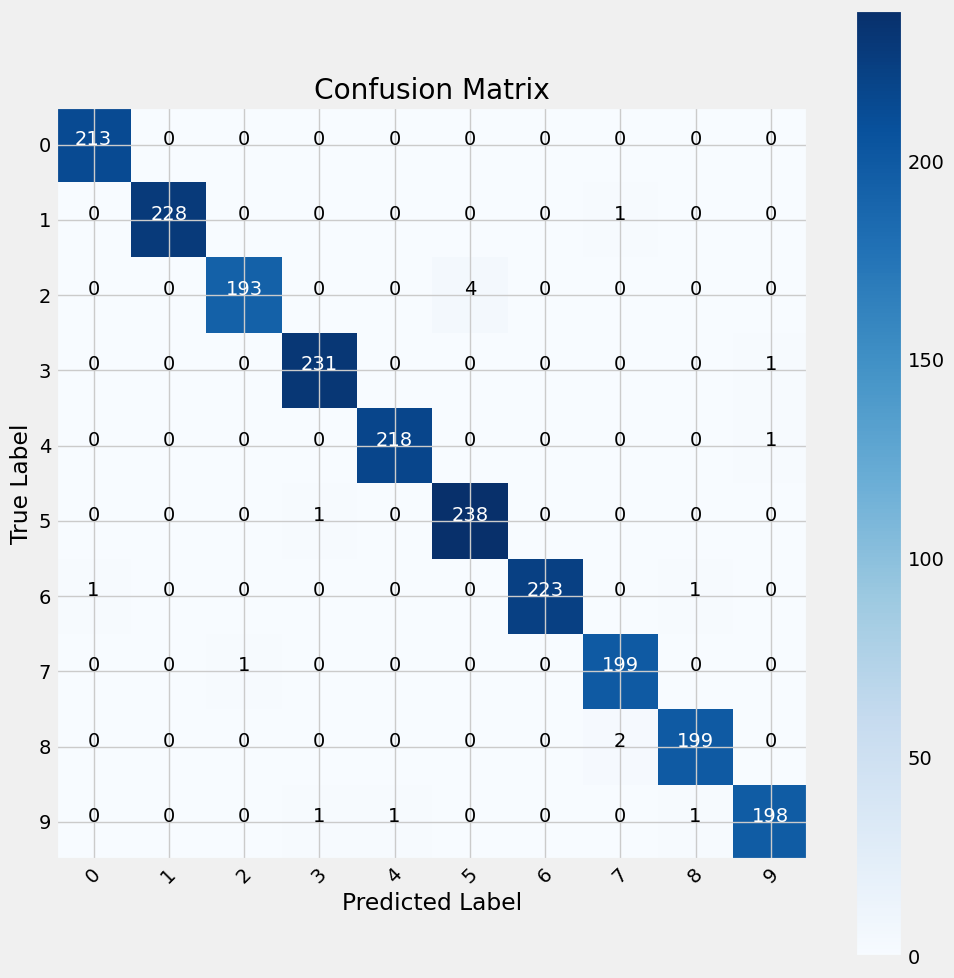

In [24]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [25]:
# Classification report
print(classification_report(test_generator.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       229
           2       0.99      0.98      0.99       197
           3       0.99      1.00      0.99       232
           4       1.00      1.00      1.00       219
           5       0.98      1.00      0.99       239
           6       1.00      0.99      1.00       225
           7       0.99      0.99      0.99       200
           8       0.99      0.99      0.99       201
           9       0.99      0.99      0.99       201

    accuracy                           0.99      2156
   macro avg       0.99      0.99      0.99      2156
weighted avg       0.99      0.99      0.99      2156



Hasil Prediksi Model EfficientNetV2B0:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


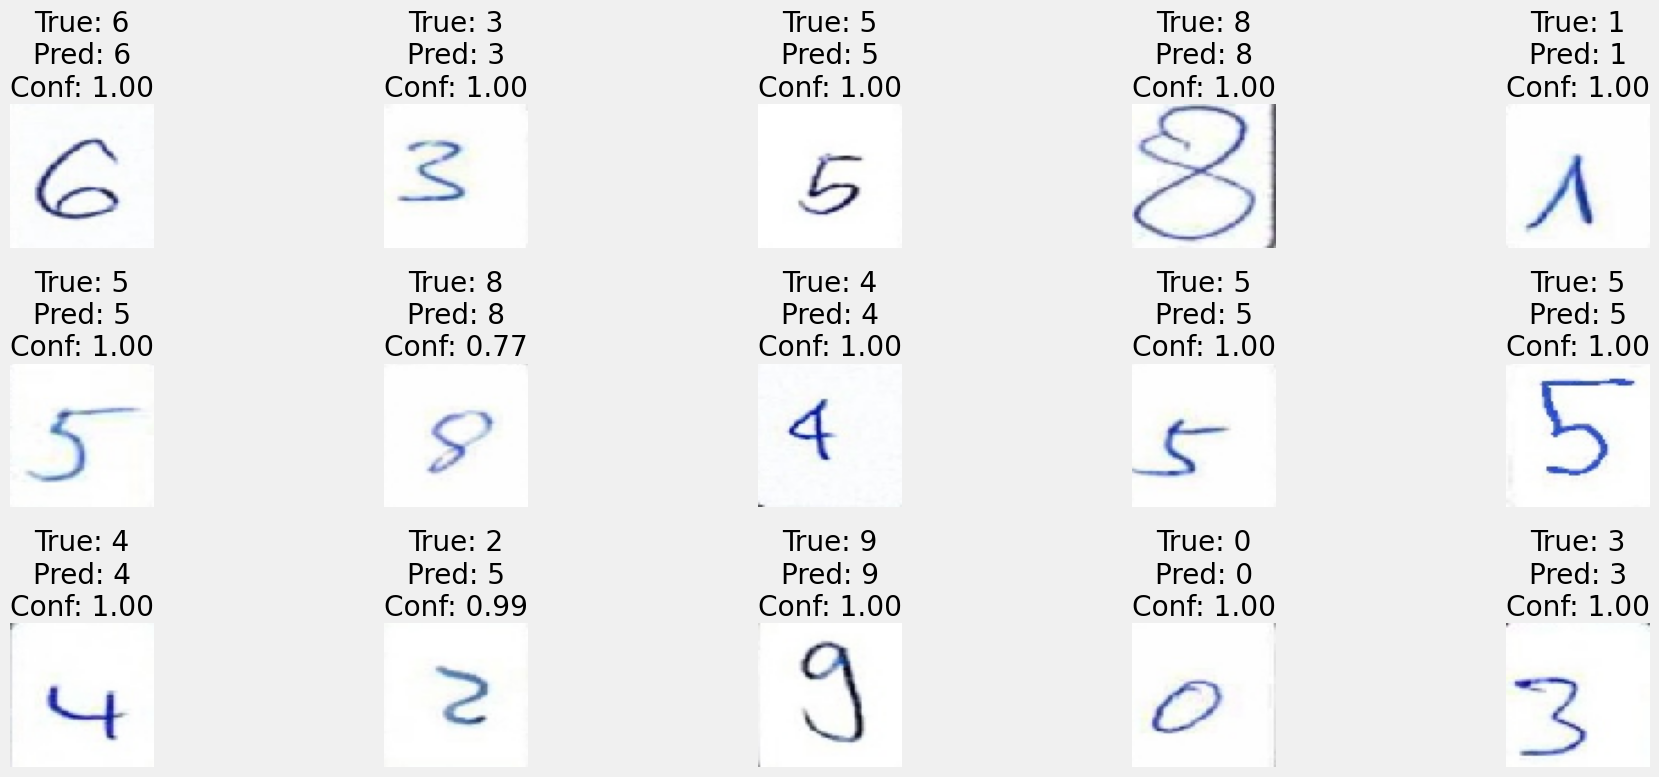

In [26]:
def plot_sample_predictions(model, test_generator, test_data, num_samples=15):
    batch_x, batch_y = next(test_generator)
    predictions = model.predict(batch_x)
    class_labels = list(test_generator.class_indices.keys())
    indices = random.sample(range(len(batch_x)), num_samples)

    fig, axes = plt.subplots(3,5, figsize=(20, 8))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        img = batch_x[idx]
        true_label = class_labels[np.argmax(batch_y[idx])]

        pred_label = class_labels[np.argmax(predictions[idx])]
        confidence = np.max(predictions[idx])

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}")

    plt.tight_layout()
    plt.show()

print("Hasil Prediksi Model EfficientNetV2B0:")
plot_sample_predictions(model_effnetv2b0, test_generator, df2)

Hasil Prediksi Model EfficientNetV2B0:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


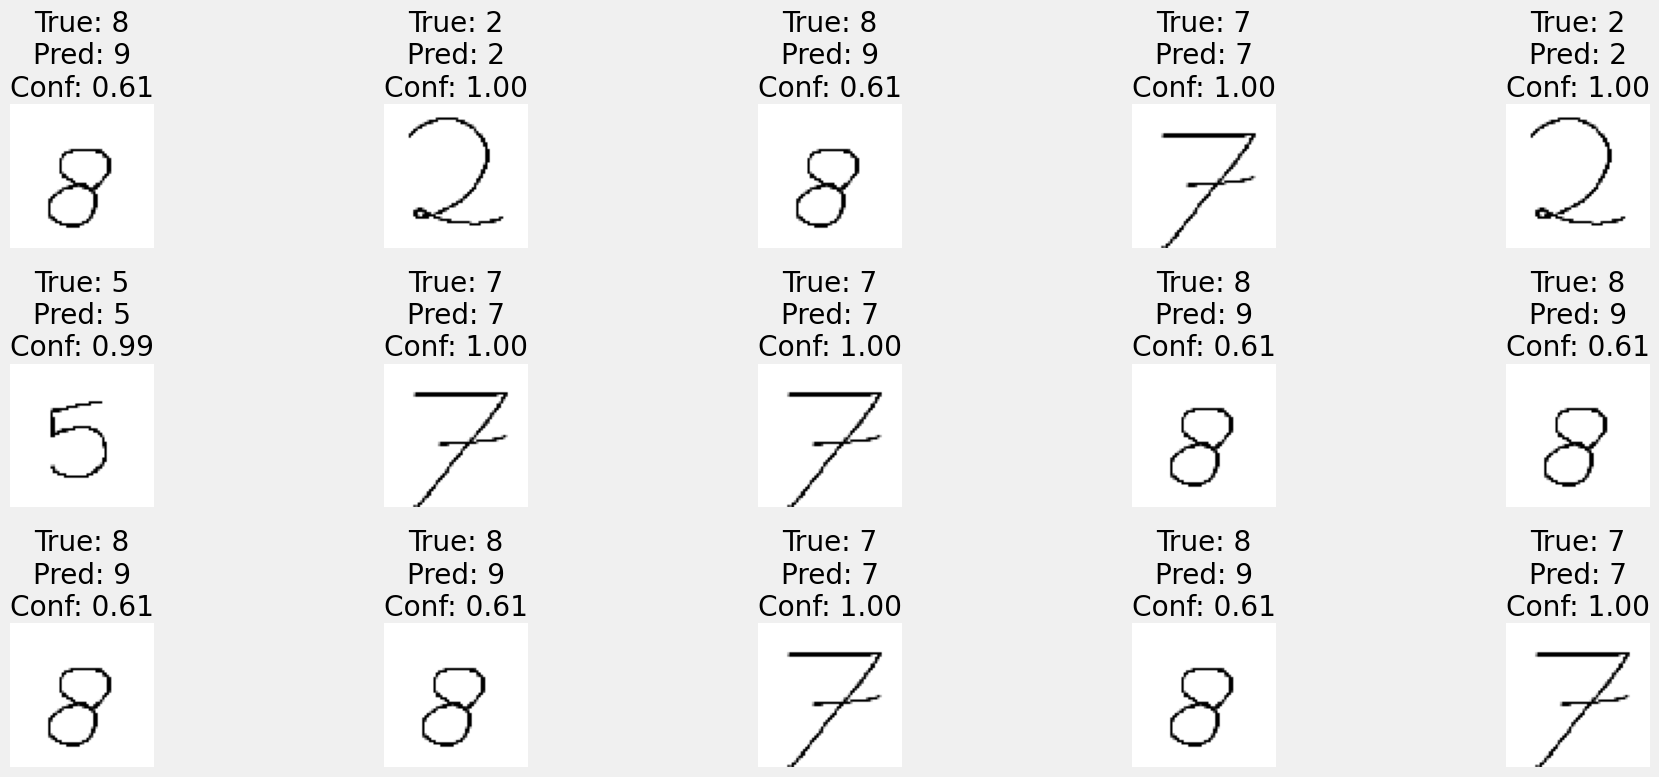

In [27]:
def plot_sample_predictions2(model, testext_generator, test_data, num_samples=15):
    batch_x, batch_y = next(testext_generator)
    predictions = model.predict(batch_x)
    class_labels = list(testext_generator.class_indices.keys())
    indices = random.sample(range(len(batch_x)), num_samples)

    fig, axes = plt.subplots(3,5, figsize=(20, 8))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        img = batch_x[idx]
        true_label = class_labels[np.argmax(batch_y[idx])]

        pred_label = class_labels[np.argmax(predictions[idx])]
        confidence = np.max(predictions[idx])

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}")

    plt.tight_layout()
    plt.show()

print("Hasil Prediksi Model EfficientNetV2B0:")
plot_sample_predictions(model_effnetv2b0, testext_generator, df2)